# CSD y CM de Actividad Evocada. 
Usemos esto como opurtunidad para poner todo el código en orden.


En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *centro de masa* (promedio vectorial) de la densidad de pozos y fuentes de corriente sobre una rebanada del hipocámpo de una rata. En este Notebook estudiaremos los datos de los experimentos evocados que hizo Franco en Agosto.
 Al parecer primero toca hacer una prueba con todo aquí mismo antes que hacer un modulo ordenado por una inconveniencia al hacer modulos (no se pueden recargar).

In [1]:
using HDF5

In [2]:
function AbreyCheca(x::AbstractString)
    #Abre el archivo de brw (acepta el nombre tal cual)
    archivo=h5open(x)
    #sacatito todas las variables que te interesan
    numcuadros=archivo["/3BRecInfo/3BRecVars/NRecFrames"][1][1]
    frecuencia=archivo["/3BRecInfo/3BRecVars/SamplingRate"][1][1]
    maxvolt=archivo["/3BRecInfo/3BRecVars/MaxVolt"][1][1]
    minvolt=archivo["/3BRecInfo/3BRecVars/MinVolt"][1][1]
    bitdepth=archivo["/3BRecInfo/3BRecVars/BitDepth"][1][1]
    duracionexperimento=numcuadros/frecuencia
    factordeescala=(maxvolt-minvolt)/2^bitdepth
    DatosCrudos=read(archivo["/3BData/Raw"])
    result=Dict("numcuadros" => numcuadros,
                "frecuencia"=> frecuencia,
                "maxvolt" => maxvolt,
                "minvolt" => minvolt,
                "bitdepth" => bitdepth,
                "duracion" => duracionexperimento,
                "factor " => factordeescala,
                "DatosCrudos"=>DatosCrudos )
    return result
                    
end

AbreyCheca (generic function with 1 method)

In [3]:
Datos=AbreyCheca("050815_1R4.brw")

Dict{ASCIIString,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "factor "     => 2.01416015625
  "frecuencia"  => 7020.800706028248
  "DatosCrudos" => 4096x210624 Array{UInt16,2}:…
  "bitdepth"    => 0x0c
  "numcuadros"  => 210624
  "duracion"    => 29.99999698312937

In [4]:
function EncuentraTrancazosRaw(datos::Array, tolerancia=1400)
    result=Int[]
    longitud=length(datos)
    jcomp=0
    for j=1:longitud
        if abs(datos[j])>tolerancia
            if j-jcomp>1
                push!(result,j)
            end
            jcomp=j
        end
    end
    return result
end


EncuentraTrancazosRaw (generic function with 2 methods)

In [5]:
exemplo=vec(Datos["DatosCrudos"][2000,:]);

In [6]:
listongas=EncuentraTrancazosRaw(exemplo)

3-element Array{Int64,1}:
  43890
 114498
 185107

In [7]:
function ActivAlrededorTrancazo(Lista::Array, xxs::Array)
    #Aqui no se le ha hecho reshape a las matrices todavia
    result=Dict{AbstractString, Array}()
    q=1
    desde=20
    hasta=480
    for j in Lista
        nomineclave="Trancazo_$q"
        result[nomineclave]=xxs[:,j-desde:j+hasta]
        #println(nomineclave)
        q+=1
    end
    return result
end

function ActividadFueraTrancazo(Lista::Array, xxs::Array)
    q=1
    desde=20
    hasta=480
    aux=trues(xxs)
    for j in Lista
        aux[j-desde:j+hasta]=false
    end
    result=zeros(1)
    aux2=find(aux)
    for j in aux2
        result=vcat(result,xxs[j])
    end
    return result
end
        
    



ActividadFueraTrancazo (generic function with 1 method)

In [8]:
ActividadRaw=ActivAlrededorTrancazo(listongas, Datos["DatosCrudos"])

Dict{AbstractString,Array{T,N}} with 3 entries:
  "Trancazo_2" => 4096x501 Array{UInt16,2}:…
  "Trancazo_1" => 4096x501 Array{UInt16,2}:…
  "Trancazo_3" => 4096x501 Array{UInt16,2}:…

In [9]:
FueraTrancazo=ActividadFueraTrancazo(listongas,exemplo);
FueraTrancazo=round(Int32,FueraTrancazo)*(-1)+2048

209122-element Array{Int32,1}:
 2048
   -2
    5
   -2
   -1
   -7
   11
    1
   25
   -8
    4
    3
   -5
    ⋮
  -13
    2
    6
   -4
  -37
   15
    3
    3
    3
    6
  -11
   -2

In [10]:
function FormaMatrizDatosCentrados(xxs::Array)
    #El array tiene que ser de 4096 por algo mas
    irrrelevante,largo=size(xxs)
    aux=Array(Int32, 64,64, largo);
    for j=1:64,k=1:64
        aux[k,j,:]=xxs[j+(k-1)*64,:]
    end
    result=round(Int32,aux)*(-1)+2048;
    aux=0
    return result
end

FormaMatrizDatosCentrados (generic function with 1 method)


Hay un montonal de canales que por la forma en que requiere ser hecho el experimento no detectaron nada o casi nada. Esos aparecen el registro como saturados en el máximo valor posible. Dado que esto es MUY inconveniente para el cálculo del CM, tenemos que detectarlos automáticamente y ponerlos en cero o ver si los esquivamos.

In [11]:
DatosCentrados=Dict{AbstractString, Array}()
for k in keys(ActividadRaw)
    DatosCentrados[k]=FormaMatrizDatosCentrados(ActividadRaw[k])
end

In [12]:
function BuscaSaturados(datos::Array, saturavalue=1700)
    (ancho,alto,largo)=size(datos)
    result=Set{Array{Int,1}}()
    arreglostd=zeros(ancho,alto)
    arregloprom=zeros(ancho,alto)
    for j=1:ancho, k=1:alto
        prom=mean(datos[k,j,:])
        arregloprom[k,j]=prom
        desviacion=std(datos[k,j,:])
        arreglostd[k,j]=desviacion
        if abs(prom)>saturavalue || desviacion<10
            push!(result, [k,j])
        end
    end
    return (result,arreglostd, arregloprom)
end

BuscaSaturados (generic function with 2 methods)

In [13]:
DictSaturados=Dict{AbstractString, Tuple}()
for k in keys(DatosCentrados)
    DictSaturados[k]=BuscaSaturados(DatosCentrados[k])
end

In [14]:
function imitaruido(x::Array)
    #Esta funcion asume que x es ruido gaussiano y lo imita.
    #Igual de largo que xx
    sigma=std(x)
    prom=mean(x)
    l=length(x)
    result=sigma*randn(l)+prom
    return result
end

function hazruido(sigma, prom, length)
    # hace ruido
    result=round(Int32, sigma*randn(l)+prom)
    return result
end



hazruido (generic function with 1 method)

In [15]:
HistogramaRuido=hist(FueraTrancazo, -100:1:100)

(-100:1:100,[0,0,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0])

In [16]:
sigmaruido=std(FueraTrancazo)
promruido=mean(FueraTrancazo)
(promruido,sigmaruido)

(-0.2902755329424929,14.409291834298928)

In [17]:
RuidoArtificial=imitaruido(FueraTrancazo)
HistoRuidoArtificial=hist(RuidoArtificial,-100:1:100)
mean(RuidoArtificial),std(RuidoArtificial)

(-0.3520801924541503,14.410473515038566)

In [18]:
using PyPlot
ion()

In [19]:
mu=promruido
sigma=sigmaruido
function gauss(x)
    return 1/(sqrt(2*pi)*sigma)*exp(-((x-mu)/sigma)^2/2)
end

gauss (generic function with 1 method)

In [20]:
xdata=collect(HistogramaRuido[1][2:end])
measuredata=HistogramaRuido[2];

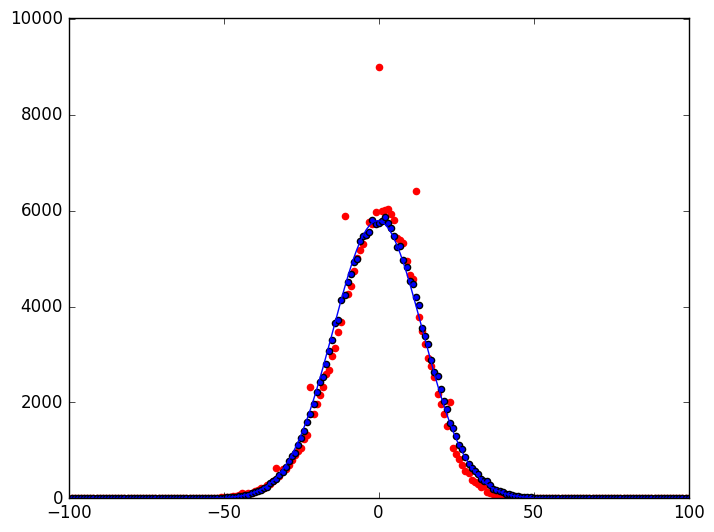

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f40f6f52c88>

In [21]:
xlim(-100,100)
ylim(-1,10005)
scatter(xdata,measuredata, color="red")
scatter(HistoRuidoArtificial[1][2:end],HistoRuidoArtificial[2])
plot(xdata, map(x->209122*gauss(x),xdata))

In [24]:
DatosDesaturados=Dict{AbstractString, Array}()

for k in keys(DatosCentrados)
    largo=length(DatosCentrados[k][1,1,:])
    lista=DictSaturados[k][1]
    aux=DatosCentrados[k]
    println(k," ",length(lista))
    
     for m in lista
        q=m[1]
        p=m[2]
        println(q," :  ",p)
        println(aux[q,p,200])
   #      hazruido(14,2,501)
     end

end

Trancazo_2 126
41 :  21
2048
36 :  26
2048
34 :  7
2048
44 :  18
2048
32 :  49
2048
34 :  34
2048
35 :  36
2048
27 :  62
2048
33 :  9
2048
18 :  27
2048
26 :  30
2048
25 :  39
2048
41 :  45
2048
45 :  1
2048
35 :  9
2048
32 :  42
2048
39 :  51
2048
5 :  56
2048
31 :  51
2048
63 :  21
2048
33 :  58
2048
28 :  51
2048
8 :  46
2048
51 :  54
2048
33 :  49
2048
9 :  56
2048
35 :  52
2048
39 :  57
2048
40 :  54
2048
37 :  14
2048
18 :  29
2048
33 :  47
2048
4 :  47
2048
26 :  12
2048
33 :  32
2048
25 :  14
2048
27 :  35
2048
34 :  48
2048
38 :  56
2048
32 :  36
2048
38 :  52
2048
29 :  32
2048
34 :  44
2048
31 :  25
2048
25 :  51
2048
27 :  54
2048
54 :  1
2048
35 :  30
2048
55 :  37
2048
11 :  11
2048
29 :  35
2048
37 :  1
2048
28 :  32
2048
42 :  35
2048
21 :  26
2048
11 :  40
2048
61 :  22
2048
25 :  40
2048
23 :  52
2048
43 :  57
2048
45 :  49
2048
43 :  14
2048
34 :  62
2048
32 :  3
2048
26 :  19
2048
38 :  20
2048
34 :  49
2048
24 :  40
2048
39 :  45
2048
64 :  8
2048
39 :  42
2048
44 

In [23]:
?DatosCentrados["Trancazo_1"][9,31,:]


126
41 :  21
